# **Clasificación de Imágenes: Redes Densas**
El objetivo de este notebook es crear una red neuronal que permita clasificar imágenes de famosos por género, en sus versiones en escala de gris y a color. Este notebook utilizará una arquitectura basada en redes densas, comparándo la *accuracy* y *loss* obtenidas contra el modelo base (que será una regresión logística).

Este notebook fue ejecutado utilizando una GPU RTX4070 (Laptop), y por tanto su versión final no ha sido probada en Google Colab, pues el entrenamiento es más rápido y no se dispone de tiempo límite. Aún asi, el notebook tiene un total de **400 epochs** de entrenamiento, por lo que no debería dar problemas.

Equipo 08:
- Tomás Daniel Expósito Torre
- David Sánz Gomez

## **Imports y Descarga de Datos**
Define los imports a utilizar en el resto del notebook, así como la descarga del fichero *gender.zip* y las funciones auxiliares. Para descargar el fichero, se debe poner la variable local a **False**.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gráficos
from matplotlib.ticker import MaxNLocator
from PIL import Image
from IPython.display import SVG
from IPython.display import clear_output
from glob import glob

# Keras
from keras.utils import load_img
from keras.api import Input
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import L1, L2, L1L2
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import model_to_dot
from keras.models import Model
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# Scikit-Learn
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Otros modulos
from googledrivedownloader import download_file_from_google_drive
import pandas as pd

E0000 00:00:1736605728.023503  582535 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736605728.026021  582535 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
local = True

In [3]:
if not local:
    aux = "'https://drive.usercontent.google.com/download?id=1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei&export=download&confirm=t&uuid=56f4f47a-291b-4ef9-895f-8886caf14b78'"
    !wget $aux -O ./gender.zip
    !unzip -qq ./gender.zip
    download_file_from_google_drive(file_id='1jifedd49sgZI2ZA6722h9R-mRh2Ciqzp',
                                    dest_path='./caras_aux.py.zip', unzip=True)
    download_file_from_google_drive(file_id='1w6rSNy0mDds1cDNBtbL9U1bkF4PiGCnK',
                                    dest_path='./funciones_auxiliares.py.zip', unzip=True)

from caras_aux import report_base_error
from funciones_auxiliares import analisis_roc, plot_confusion_matrix    

## **Funciones Auxiliares**
Esta sección define una serie de funciones que ayudan a graficar el proceso de entrenamiento de la arquitectura elegida.

In [4]:
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, figsize=(10,4)):
    plt.figure(figsize=figsize)
    i = np.argmax(val_acc)
    train_accuracy, validation_accuracy = np.array(tr_acc) * 100, np.array(val_acc) * 100
    train_loss, validation_loss = np.array(tr_loss), np.array(val_loss)
    epochs = len(train_accuracy)
    
    # Accuracy
    ax = plt.subplot(1,2,1)
    plt.plot(np.arange(epochs) + 1, train_accuracy)
    plt.plot(np.arange(epochs) + 1, validation_accuracy)
    plt.plot(i + 1, validation_accuracy[i], 'or')
    
    plt.title('Accuracy del Modelo (%)', fontsize=18)
    plt.ylabel('Accuracy (%)', fontsize=18)
    plt.xlabel('Época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(epochs) + 1, train_loss)
    plt.plot(np.arange(epochs) + 1, validation_loss)
    plt.plot(i + 1, validation_loss[i], 'or')
    
    plt.title('Loss del modelo', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.xlabel('Época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.show()

def loadImages(root, factor=1, nimages=False, color=False):
    files = os.listdir(root)
    if not nimages:
        nimages = len(files)
    if not color:
        X = np.zeros((nimages, int(factor*250)*int(factor*250)))
    else:
        X = np.zeros((nimages, 3*int(factor*250)*int(factor*250)))
    for i in range(nimages):
        f = os.path.join(root, files[i])
        if not color:
            img = Image.open(f).convert('L')
        else:
            img = Image.open(f)
        dims = np.shape(img)
        if i==0:
            h = int(factor*dims[0])
            w = int(factor*dims[1])
        img = img.resize((h, w))
        X[i,:] = np.ravel(img)
    return X, h, w
    
def build_model(layers, color=False):
    model = Sequential()
    if not color:
        model.add(Input(shape=(xtrain_gray.shape[1],)))
    else:
        model.add(Input(shape=(xtrain_color.shape[1],)))
    model.add(Dropout(rate=0.2))
    for neurons in layers:
        model.add(Dense(neurons, activation='relu'))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])
    return model

## **Exploración y Preparación de Datos**
En esta sección se realiza una exploración básica de los datos en gris y color, así como un preprocesado (normalización) para poder trabajar con redes neuronales. Para este problema, se hará uso de un conjunto de **test** del **10%** de la muestra, un conjunto de **train** del **63%** y uno de **validación** del **27%**.

In [5]:
factor = 0.3

females, _, _ = loadImages('./gender/female', factor=factor, nimages=1000)
males, _, _ = loadImages('./gender/male', factor=factor, nimages=1000)

x_gray = np.concatenate((females, males))
y_gray = np.concatenate((np.zeros(len(females)), np.ones(len(males))))

females, _, _ = loadImages('./gender/female', factor=factor, nimages=1000, color=True)
males, _, _ = loadImages('./gender/male', factor=factor, nimages=1000, color=True)

x_color = np.concatenate((females, males))
y_color = np.concatenate((np.zeros(len(females)), np.ones(len(males))))

samples, features = x_gray.shape
_, color_features = x_color.shape
targets, ntargets = np.array(['female', 'male']), 2

print("Estadísticas básicas de la base de datos:")
print(f"\tNombres de clases: {targets}")
print(f"\tNúmero de clases: {ntargets}")
print(f"\tNúmero de muestras: {samples}")
print()


print("Estadísticas de la versión en gris")
print(f"\tNúmero de atributos: {features}")
print(f"\tRango de Variables: [{x_gray.min()}, {x_gray.max()}]")
print(f"\tRango de Variables Normalizado: [{x_gray.min() / 255}, {x_gray.max() / 255}]")
print()
x_gray /= 255


print("Estadísticas de la versión en color")
print(f"\tNúmero de atributos: {color_features}")
print(f"\tRango de Variables: [{x_color.min()}, {x_color.max()}]")
print(f"\tRango de Variables Normalizado: [{x_color.min() / 255}, {x_color.max() / 255}]")
x_color /= 255

Estadísticas básicas de la base de datos:
	Nombres de clases: ['female' 'male']
	Número de clases: 2
	Número de muestras: 2000

Estadísticas de la versión en gris
	Número de atributos: 5625
	Rango de Variables: [0.0, 255.0]
	Rango de Variables Normalizado: [0.0, 1.0]

Estadísticas de la versión en color
	Número de atributos: 16875
	Rango de Variables: [0.0, 255.0]
	Rango de Variables Normalizado: [0.0, 1.0]


Dimensiones de datos (gris)
- Entrenamiento	x:(1260, 5625)	y:(1260,)
- Validación	x:(540, 5625)	y:(540,)
- Test		x:(200, 5625)	y:(200,)
Dimensiones de datos (color)
- Entrenamiento	x:(1260, 16875)	y:(1260,)
- Validación	x:(540, 16875)	y:(540,)
- Test		x:(200, 16875)	y:(200,)
Probabilidades
- Priori de la clase 0 en training: 0.500
- Priori de la clase 1 en training: 0.500
- Clase mayoritaria en training: 0

- Priori de la clase 0 en test: 0.500
- Priori de la clase 1 en test: 0.500
- Score de la clasificacion por mayoria en test: 0.500


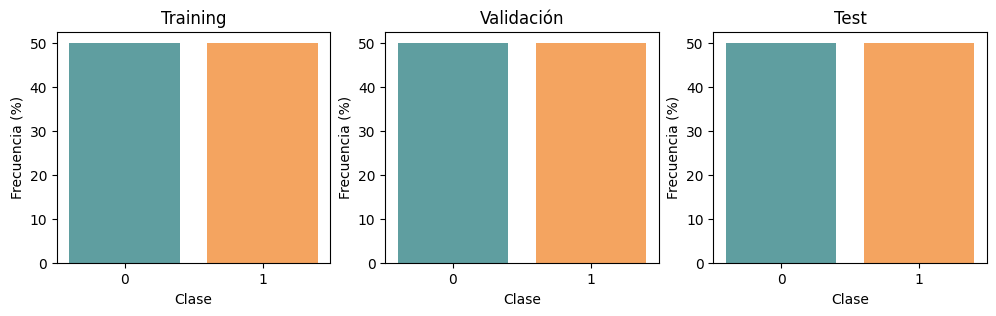

In [6]:
xtrain_gray, xtest_gray, ytrain_gray, ytest_gray = train_test_split(x_gray, y_gray, test_size=0.1, random_state=42, stratify=y_gray)
xtrain_gray, xval_gray, ytrain_gray, yval_gray = train_test_split(xtrain_gray, ytrain_gray, test_size=0.3, random_state=42, stratify=ytrain_gray)

xtrain_color, xtest_color, ytrain_color, ytest_color = train_test_split(x_color, y_color, test_size=0.1, random_state=42, stratify=y_color)
xtrain_color, xval_color, ytrain_color, yval_color = train_test_split(xtrain_color, ytrain_color, test_size=0.3, random_state=42, stratify=ytrain_color)

print("Dimensiones de datos (gris)")
print(f"- Entrenamiento\tx:{xtrain_gray.shape}\ty:{ytrain_gray.shape}")
print(f"- Validación\tx:{xval_gray.shape}\ty:{yval_gray.shape}")
print(f"- Test\t\tx:{xtest_gray.shape}\ty:{ytest_gray.shape}")

print("Dimensiones de datos (color)")
print(f"- Entrenamiento\tx:{xtrain_color.shape}\ty:{ytrain_color.shape}")
print(f"- Validación\tx:{xval_color.shape}\ty:{yval_color.shape}")
print(f"- Test\t\tx:{xtest_color.shape}\ty:{ytest_color.shape}")

print("Probabilidades")
report_base_error(xtrain_gray, ytrain_gray, xtest_gray, ytest_gray)

plt.figure(figsize=(12,3))
for i, (y_, title) in enumerate(zip([ytrain_gray, yval_gray, ytest_gray], ['Training', 'Validación', 'Test']), start=1):
    ax = plt.subplot(1,3,i)
    clases, counts = np.unique(y_, return_counts=True)
    plt.bar(clases, counts * 100./len(y_), color=["cadetblue", "sandybrown"])
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Frecuencia (%)')
    ax.set_xticks(clases)
plt.show()

## **Modelo Base: Regresión Logística**
Esta sección define el modelo base contra el que se comparará la arquitectura a implementar. Se entrenan regresiones logísticas tanto para la versión en **gris** como a **color** de las fotos.

In [7]:
logreg = LogisticRegression(max_iter=1000, C=0.1)
logreg.fit(xtrain_gray, ytrain_gray)

LogisticRegression(C=0.1, max_iter=1000)

In [8]:
logcreg = LogisticRegression(max_iter=1000, C=0.1)
logcreg.fit(xtrain_color, ytrain_color)

LogisticRegression(C=0.1, max_iter=1000)

In [9]:
print("Scores del modelo base (gris)")
print(f"- Training:\t{logreg.score(xtrain_gray, ytrain_gray)}")
print(f"- Validación:\t{logreg.score(xval_gray, yval_gray)}")
print(f"- Test:\t\t{logreg.score(xtest_gray, ytest_gray)}")

print("Scores del modelo base (color)")
print(f"- Training:\t{logcreg.score(xtrain_color, ytrain_color)}")
print(f"- Validación:\t{logcreg.score(xval_color, yval_color)}")
print(f"- Test:\t\t{logcreg.score(xtest_color, ytest_color)}")

Scores del modelo base (gris)
- Training:	0.9603174603174603
- Validación:	0.8074074074074075
- Test:		0.78
Scores del modelo base (color)
- Training:	0.9976190476190476
- Validación:	0.8166666666666667
- Test:		0.795


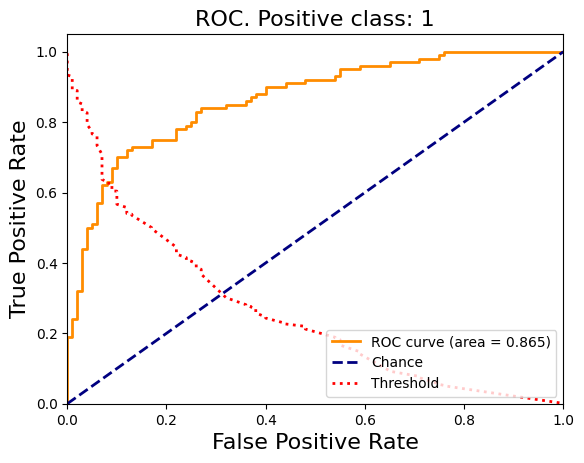

In [10]:
analisis_roc(y=ytest_gray, positive_class_scores=logreg.predict_proba(xtest_gray)[:,1], POSITIVE_CLASS=1)

Confusion matrix, without normalization
[[83 17]
 [27 73]]


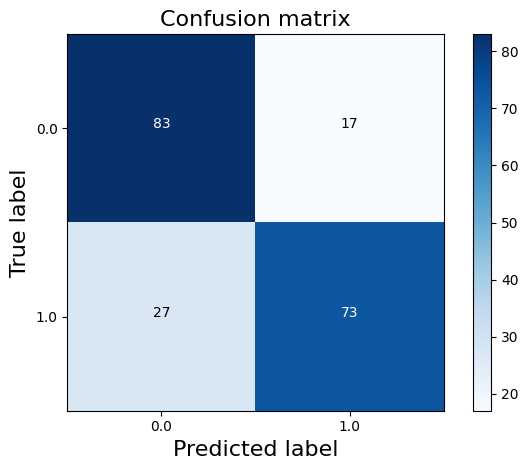

In [11]:
plot_confusion_matrix(y=ytest_gray, y_pred=logreg.predict(xtest_gray))

## **Arquitectura Densa Inicial (Keras)**

En esta sección se explorará de manera inicial y sencilla posibles arquitecturas del modelo de clasificación para caras con Keras. Esto consistirá en simplemente elegir el número de capas ocultas y neuronas por capa que produzcan los mejores valores de *accuracy* y *loss* en el dataset en **gris** (ya que es más rápida de entrenar que su contraparte a color).

In [12]:
layer_grid = []
epochs = 20
for i in range(3,7+1):
    for j in range(3,8+1):
        layer_grid.append([i] * j)
print(f"Layer architectures to test: {len(layer_grid)}") 

Layer architectures to test: 30


In [13]:
scores = []
print("Training model: ")
for i, layers in enumerate(layer_grid):
    print(i, end=" ")
    model=build_model(layers, color=False)
    history = model.fit(xtrain_gray, ytrain_gray, epochs=100, batch_size=32, validation_data=(xval_gray, yval_gray), verbose=0)
    scores.append((history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']))

Training model: 
0 

I0000 00:00:1736605783.104999  582535 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5656 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1736605784.064088  582723 service.cc:148] XLA service 0x7b6cf400b250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736605784.064105  582723 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1736605784.148996  582723 cuda_dnn.cc:529] Loaded cuDNN version 90600
I0000 00:00:1736605784.979722  582723 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [14]:
enumscores = []
for i, score in enumerate(scores):
    j = np.argmax(score[1]) # Consideramos el checkpoint aquel con más accuracy
    enumscores.append((i, score[0][j], score[1][j], score[2][j], score[3][j]))

In [15]:
top5 = sorted(enumscores, key=lambda x: -x[2])[:5]
print("Arquitecturas candidatas (por mayor accuracy en validación):")
for i in range(0, 5):
    print(f"{i+1}. Layers: {layer_grid[top5[i][0]]}")
    print(f"\tAcc (train):\t{top5[i][1]}")
    print(f"\tAcc (val):\t{top5[i][2]}")
    print(f"\tLoss (train):\t{top5[i][3]}")
    print(f"\tLoss (val):\t{top5[i][4]}")

top5 = sorted(enumscores, key=lambda x: x[4])[:5]
print("Arquitecturas candidatas (por menor loss en validación):")
for i in range(0, 5):
    print(f"{i+1}. Layers: {layer_grid[top5[i][0]]}")
    print(f"\tAcc (train):\t{top5[i][1]}")
    print(f"\tAcc (val):\t{top5[i][2]}")
    print(f"\tLoss (train):\t{top5[i][3]}")
    print(f"\tLoss (val):\t{top5[i][4]}")

Arquitecturas candidatas (por mayor accuracy en validación):
1. Layers: [5, 5, 5, 5, 5, 5, 5]
	Acc (train):	0.8071428537368774
	Acc (val):	0.8240740895271301
	Loss (train):	0.4889177680015564
	Loss (val):	0.5234401226043701
2. Layers: [6, 6, 6, 6, 6]
	Acc (train):	0.8103174567222595
	Acc (val):	0.8222222328186035
	Loss (train):	0.4128132164478302
	Loss (val):	0.43780404329299927
3. Layers: [3, 3, 3, 3]
	Acc (train):	0.7960317730903625
	Acc (val):	0.8185185194015503
	Loss (train):	0.4475525915622711
	Loss (val):	0.46272313594818115
4. Layers: [7, 7, 7]
	Acc (train):	0.8507936596870422
	Acc (val):	0.8185185194015503
	Loss (train):	0.35123780369758606
	Loss (val):	0.4315936267375946
5. Layers: [5, 5, 5, 5, 5, 5, 5, 5]
	Acc (train):	0.803174614906311
	Acc (val):	0.8166666626930237
	Loss (train):	0.4703102707862854
	Loss (val):	0.49005046486854553
Arquitecturas candidatas (por menor loss en validación):
1. Layers: [7, 7, 7]
	Acc (train):	0.8507936596870422
	Acc (val):	0.8185185194015503
	Lo

## **Arquitectura Densa Final (Keras)**
En esta sección se define en mayor profundidad una de las arquitecturas candidatas vistas en la sección anterior. Para el momento de ejecutar estas celdas, dicha estructura tiene **5** capas ocultas de **7** neuronas cada una. El comportamiento que observamos modificando base arquitectura (3-5 capas, dropout, learn-rate, regularización y canales de la imagen) muestra scores para validación contenidos en el rango **[0.78, 0.82]**. Estos resultados varían incluso entre la misma arquitectura, donde asumimos que se debe a dos razones:
1. **Sistema de ficheros.** Las imagenes son cargadas según la función `os.listdir` en `loadImages`, que puede variar los datos de test, training y validación. El método de separación de datos es siepmre el mismo ya que están inicializados con un `random_state`.
2. **MLP.** Depende de la forma en la que se inicialicen los pesos (que es aleatoria), se acaba en un mínimo local u otro. Una posible solución a este problema sería entrenar un ensemble de MLPs y quedarse con el mejor, o promediarlos para compensar errores.

### **Modelo en Gris**

In [16]:
gray = Sequential()
gray.add(Input(shape=(xtrain_gray.shape[1],)))
gray.add(Dropout(rate=0.4))
gray.add(Dense(7, activation='relu', kernel_regularizer=L2(0.05)))
gray.add(Dense(7, activation='relu'))
gray.add(Dense(7, activation='relu'))
gray.add(Dense(7, activation='relu'))
gray.add(Dense(7, activation='relu'))

gray.add(Dense(1, activation='sigmoid'))
gray.compile(loss="binary_crossentropy", optimizer=Adam(0.00025), metrics=["accuracy"])

In [17]:
atr, aval, ltr, lval = [], [], [], []
epochs = 200
checkpoint = ModelCheckpoint("best_model_gray.keras", monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

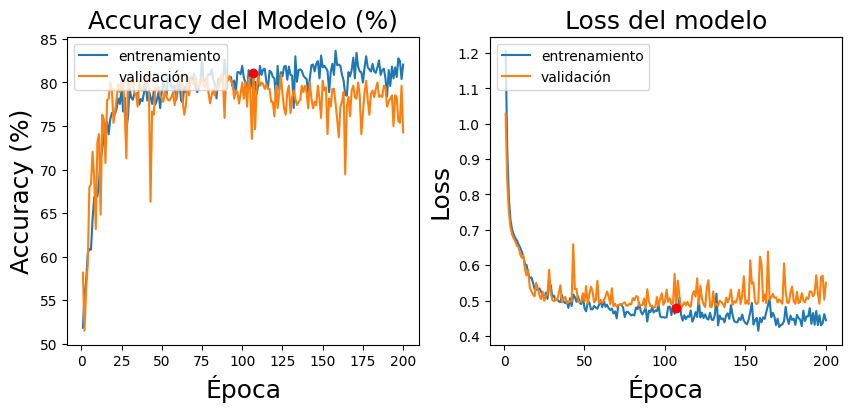

In [18]:
for e in range(epochs):
    history = gray.fit(xtrain_gray, ytrain_gray, epochs=1, batch_size=32, validation_data=(xval_gray, yval_gray), verbose=0, callbacks=[checkpoint])
    atr.append(history.history['accuracy'][0]), aval.append(history.history['val_accuracy'][0])
    ltr.append(history.history['loss'][0]), lval.append(history.history['val_loss'][0])

    if len(atr) % 5 == 0:
        clear_output()
        grafica_entrenamiento(atr, aval, ltr, lval)

In [19]:
max(aval)

0.8111110925674438

In [20]:
try:
    prev_model = load_model("N1E08_gray.keras")
    gray = load_model("best_model_gray.keras")
    
    pa = np.mean(yval_gray == np.round(prev_model.predict(xval_gray, verbose=0).flatten()))
    a = np.mean(yval_gray == np.round(gray.predict(xval_gray, verbose=0).flatten()))
    
    print("Previous model found, comparing obtained scores...")
    if a > pa:
        print(f"New model is better ({a} vs {pa}), saving...")
        gray.save("N1E08_gray.keras")
    else:
        print(f"Old model is better ({a} vs {pa}), skipping save...")
        gray = prev_model

except Exception as _:
    print("No previous model found, saving...")
    gray = load_model("best_model_gray.keras")
    gray.save("N1E08_gray.keras")
    

Previous model found, comparing obtained scores...
Old model is better (0.8111111111111111 vs 0.8185185185185185), skipping save...


### **Modelo en Color**

In [21]:
color = Sequential()
color.add(Input(shape=(xtrain_color.shape[1],)))
color.add(Dropout(rate=0.4))
color.add(Dense(7, activation='relu', kernel_regularizer=L2(0.05)))
color.add(Dense(7, activation='relu'))
color.add(Dense(7, activation='relu'))
color.add(Dense(7, activation='relu'))
color.add(Dense(7, activation='relu'))

color.add(Dense(1, activation='sigmoid'))
color.compile(loss="binary_crossentropy", optimizer=Adam(0.00025), metrics=["accuracy"])

In [22]:
atr, aval, ltr, lval = [], [], [], []
epochs = 200
checkpoint = ModelCheckpoint("best_model_color.keras", monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

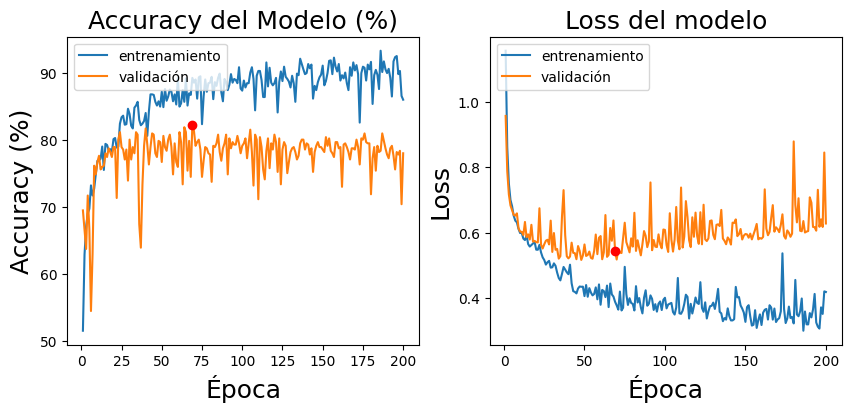

In [23]:
for e in range(epochs):
    history = color.fit(xtrain_color, ytrain_color, epochs=1, batch_size=32, validation_data=(xval_color, yval_color), verbose=0, callbacks=[checkpoint])
    atr.append(history.history['accuracy'][0]), aval.append(history.history['val_accuracy'][0])
    ltr.append(history.history['loss'][0]), lval.append(history.history['val_loss'][0])

    if len(atr) % 5 == 0:
        clear_output()
        grafica_entrenamiento(atr, aval, ltr, lval)

In [24]:
max(aval)

0.8222222328186035

In [25]:
try:
    prev_model = load_model("N1E08_color.keras")
    color = load_model("best_model_color.keras")
    
    pa = np.mean(yval_color == np.round(prev_model.predict(xval_color, verbose=0).flatten()))
    a = np.mean(yval_color == np.round(color.predict(xval_color, verbose=0).flatten()))
    
    print("Previous model found, comparing obtained scores...")
    if a > 1:
        print(f"New model is better ({a} vs {pa}), saving...")
        color.save("N1E08_color.keras")
    else:
        print(f"Old model is better ({a} vs {pa}), skipping save...")
        color = prev_model

except Exception as e:
    print("No previous model found, saving...")
    color = load_model("best_model_color.keras")
    color.save("N1E08_color.keras")
    

Previous model found, comparing obtained scores...
Old model is better (0.8222222222222222 vs 0.8277777777777777), skipping save...


## **Análisis del Mejor Modelo**

Con las consideraciones de la sección anterior, así como los resultados mostrados en este análisis, no pensamos que valga la pena entrenar este modelo con arquitecturas densas en comparación a una regresión logística.

De las dos arquitecturas densas entrenadas, el mejor modelo que observamos es el *grayscale*. Si bien el modelo a color tiene una accuracy máxima mayor (~81.5% vs ~82.7%), la *loss* del modelo a color comienza a degenerar temprano, haciendo que esté mucho menos segura de sus predicciones. Eso puede verse si se fueran a analizar ambas curvas ROC, donde el area bajo la curva de la versión en color es de **0.83** en lugar del **0.868** de la versión grayscale.

In [26]:
probs_gray = gray.predict(xtest_gray, verbose=0).flatten()
ypreds_gray = np.round(probs_gray)

probs_color = color.predict(xtest_color, verbose=0).flatten()
ypreds_color = np.round(probs_color)

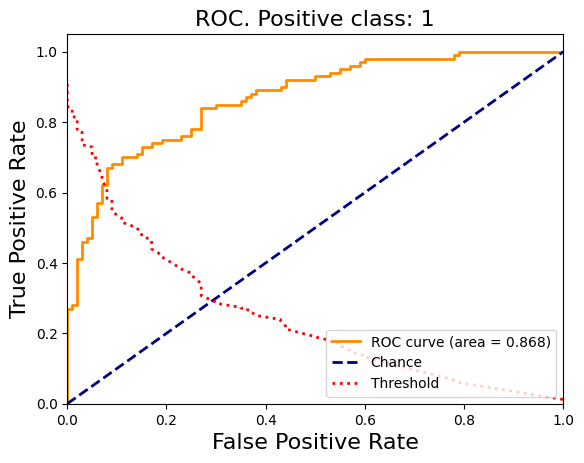

In [27]:
analisis_roc(y=ytest_gray, positive_class_scores=probs_gray, POSITIVE_CLASS=1)

Confusion matrix, without normalization
[[86 14]
 [30 70]]


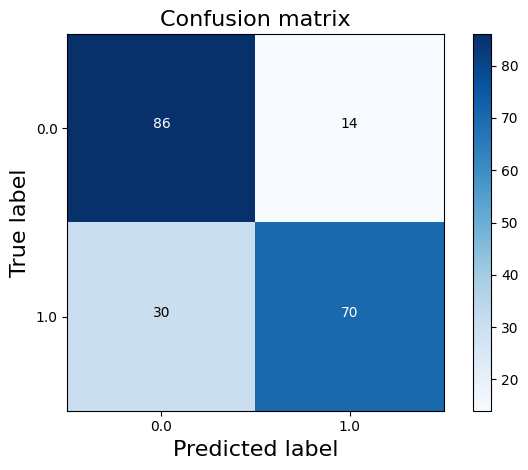

In [28]:
plot_confusion_matrix(y=ytest_gray, y_pred=ypreds_gray)

In [29]:
print("Scores del modelo base (gris)")
print(f"- Training:\t{logreg.score(xtrain_gray, ytrain_gray)}")
print(f"- Validación:\t{logreg.score(xval_gray, yval_gray)}")
print(f"- Test:\t\t{logreg.score(xtest_gray, ytest_gray)}")

print("Scores del modelo keras (gris)")
print(f"- Training:\t{np.mean(ytrain_gray == np.round(gray.predict(xtrain_gray, verbose=0).flatten()))}")
print(f"- Validación:\t{np.mean(yval_gray == np.round(gray.predict(xval_gray, verbose=0).flatten()))}")
print(f"- Test:\t\t{np.mean(ytest_gray == ypreds_gray)}")


Scores del modelo base (gris)
- Training:	0.9603174603174603
- Validación:	0.8074074074074075
- Test:		0.78
Scores del modelo keras (gris)
- Training:	0.8714285714285714
- Validación:	0.8185185185185185
- Test:		0.78


In [30]:
print("Scores del modelo base (color)")
print(f"- Training:\t{logcreg.score(xtrain_color, ytrain_color)}")
print(f"- Validación:\t{logcreg.score(xval_color, yval_color)}")
print(f"- Test:\t\t{logcreg.score(xtest_color, ytest_color)}")

print("Scores del modelo keras (color)")

print(f"- Training:\t{np.mean(ytrain_color == np.round(color.predict(xtrain_color, verbose=0).flatten()))}")
print(f"- Validación:\t{np.mean(yval_color == np.round(color.predict(xval_color, verbose=0).flatten()))}")
print(f"- Test:\t\t{np.mean(ytest_color == ypreds_color)}")


Scores del modelo base (color)
- Training:	0.9976190476190476
- Validación:	0.8166666666666667
- Test:		0.795
Scores del modelo keras (color)
- Training:	0.9571428571428572
- Validación:	0.8277777777777777
- Test:		0.785
